## Import Libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.models import load_model

import tensorflow_hub as hub

from PIL import Image

## Importing the dataset


### Image Preprocessing
The dataset contains images in the PNG format, some of which have transparency. In order to ensure these images do not appear black when processed by the model, we need to set a white background for them. 

The following code iterates through the dataset directory, identifies PNG images with transparency, and sets a white background for them.

In [3]:
data_dir = "/Users/anna-alexandradanchenko/local/IdentMathFunc/Math-Functions-Identification/data"
img_height = 224
img_width = 224


# Some images are png with transparency. We need to set the white background for them so they won't appear black for the model. 
for subdir, dirs, files in os.walk(data_dir): # Iterate throught all the levels of the directories 
    for file in files:
        if file.endswith('.png'):
            img = Image.open(os.path.join(subdir, file))
            if img.mode == "RGBA":                     # Choose only images with transparency
                white_background_image = Image.new("RGBA", img.size, "WHITE") # Create a white rgba background
                white_background_image.paste(img, (0, 0), img) # Paste original png image on top of the white background
                final_img = white_background_image.convert("RGB")

                final_img.save((os.path.join(subdir, file))) # Save the image with the same filename

### Dataset Creation

Let's create a tensordlow dataset from the images for easy manipulation and training. 

The dataset will be split into training and validation sets, 1/4 of the images will be used for validation. The images are resized to 224x224 pixels, as this is the format that the pre-trained models expects.

In [4]:
# Converts images to floating-point tensors automatically

df_train_ = image_dataset_from_directory(
    data_dir,

    validation_split=0.25,
    subset="training",

    labels='inferred',
    label_mode="categorical",
        
    color_mode='rgb',

    image_size=[img_height, img_width],

    seed = 123,     
    interpolation='bilinear',
    shuffle=True
)

df_valid_ = image_dataset_from_directory(
    data_dir,

    validation_split=0.25,
    subset="validation",
    
    labels='inferred',
    label_mode="categorical",
    
    color_mode='rgb',

    image_size=[img_height, img_width],

    seed = 123,     
    interpolation='bilinear',
    shuffle=False
)


Found 1582 files belonging to 16 classes.
Using 1187 files for training.
Found 1582 files belonging to 16 classes.
Using 395 files for validation.


In [5]:
class_names = df_train_.class_names
print(class_names)

['absolute_linear', 'cubic', 'cubic_root', 'exponential', 'linear', 'logarithmic', 'negative_cubic', 'negative_cubic_root', 'negative_exponential', 'negative_linear', 'negative_quadratic', 'negative_square_root', 'not_valid', 'quadratic', 'square_negative_root', 'square_root']


## Data Visualization

As can be seen from the data sample below, the training data is already diverse and augmented, therefore no further data preprocessing is needed.

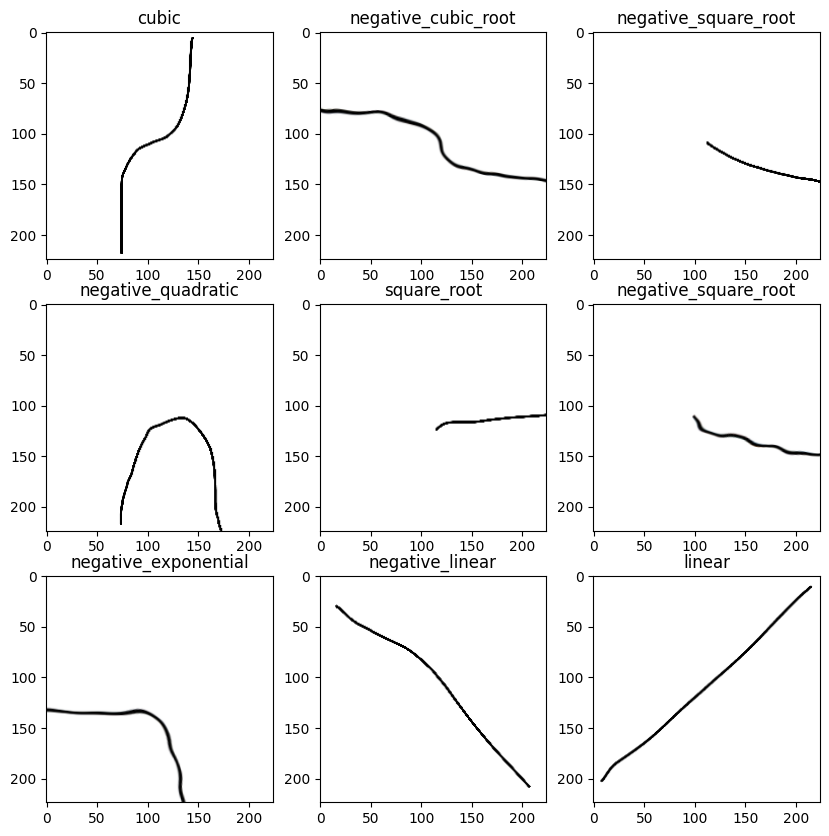

In [6]:
plt.figure(figsize=(10, 10))

for images, labels in df_train_.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    label_index = np.argmax(labels[i].numpy()) # Returns the indices of the maximum values.
    plt.title(class_names[label_index])

## Dataset Optimization

Optimizing the training process by cashing the dataset to memory to avoid reading the data from disk on each epoch. Prefetching the data to allow the model to train on the current batch while the next batch is being prepared.

In [7]:
AUTOTUNE = tf.data.AUTOTUNE

df_train = (
    df_train_
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)
df_valid = (
    df_valid_
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 16), dtype=tf.float32, name=None))>

## Model Definition

The model architecture is defined using the Sequential API, utilizing a pre-trained model as the base and adding Dense layers on top of it.

 The pre-trained model is **MobileNetV2** feature extractor, which is trained on the ImageNet dataset. It was chosen for its exceptional speed, lightweightness and effectiveness, especially given the small number of classes and the simplicity of the data. Fully connected layers classify images into 16 classes.

 The Rescaling layer is commented out because it does not yield better results in our case, likely due to the pre-trained model's internal rescaling.

In [16]:
model = Sequential([
    # layers.Rescaling(1./255, input_shape=(224, 224, 3)),
    hub.KerasLayer(
        "https://www.kaggle.com/models/google/mobilenet-v2/TensorFlow2/035-224-feature-vector/2",
        trainable=False
        ),  
    layers.Flatten(), # Used to transition from convolutional layer to fully connected layer
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(16, activation='softmax')
])

In [17]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)

The model fully converges during 12 epochs, reaching a validation accuracy of almost 1.

In [18]:
history = model.fit(
    df_train,
    validation_data=df_valid,
    epochs=12
    )

Epoch 1/12
38/38 [==============================] - 5s 104ms/step - loss: 1.4747 - accuracy: 0.6352 - val_loss: 0.6032 - val_accuracy: 0.8810
Epoch 2/12
38/38 [==============================] - 4s 93ms/step - loss: 0.2591 - accuracy: 0.9570 - val_loss: 0.1883 - val_accuracy: 0.9595
Epoch 3/12
38/38 [==============================] - 4s 105ms/step - loss: 0.1026 - accuracy: 0.9848 - val_loss: 0.1001 - val_accuracy: 0.9747
Epoch 4/12
38/38 [==============================] - 4s 102ms/step - loss: 0.0633 - accuracy: 0.9916 - val_loss: 0.0710 - val_accuracy: 0.9823
Epoch 5/12
38/38 [==============================] - 4s 97ms/step - loss: 0.0448 - accuracy: 0.9949 - val_loss: 0.0601 - val_accuracy: 0.9873
Epoch 6/12
38/38 [==============================] - 4s 100ms/step - loss: 0.0333 - accuracy: 0.9975 - val_loss: 0.0479 - val_accuracy: 0.9873
Epoch 7/12
38/38 [==============================] - 4s 96ms/step - loss: 0.0257 - accuracy: 0.9975 - val_loss: 0.0383 - val_accuracy: 0.9924
Epoch 8/1

<Axes: >

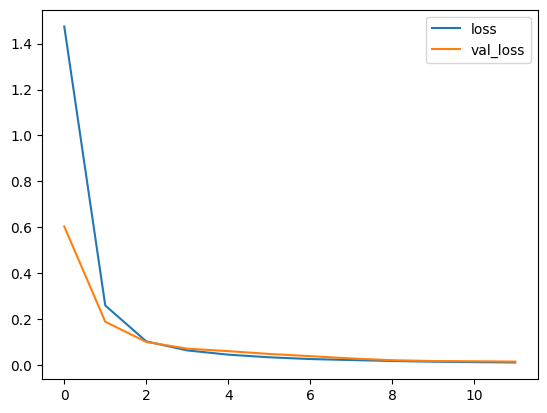

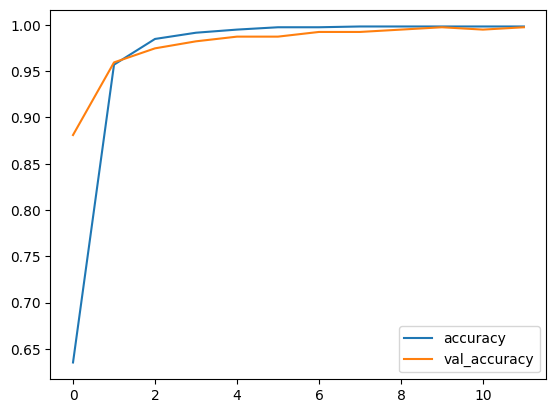

In [19]:
history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['accuracy', 'val_accuracy']].plot()

## Save and Test the Model

In [20]:
model.save("model.keras")

In [21]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 1280)              410208    
                                                                 
 flatten_1 (Flatten)         (None, 1280)              0         
                                                                 
 dense_3 (Dense)             (None, 128)               163968    
                                                                 
 dense_4 (Dense)             (None, 64)                8256      
                                                                 
 dense_5 (Dense)             (None, 16)                1040      
                                                                 
Total params: 583472 (2.23 MB)
Trainable params: 173264 (676.81 KB)
Non-trainable params: 410208 (1.56 MB)
_________________________________________________________________


Let's make a prediction on one image in order to test our model. 

In [22]:
model_loaded = load_model("model.keras", custom_objects={'KerasLayer':hub.KerasLayer})
img = Image.open("/Users/anna-alexandradanchenko/local/IdentMathFunc/Math-Functions-Identification/data/negative_linear/function_0.9_-1.5_9.0.png").resize((224, 224))
img = np.array(img)
img = np.expand_dims(img, axis=0)
print(img.shape)
prediction = model_loaded.predict(img)
pred_class = np.argmax(prediction)
print(class_names[pred_class])

(1, 224, 224, 3)
1/1 [==============================] - 0s 245ms/step
negative_linear
